In [71]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np
import datetime
import os
from pprint import pprint
import matplotlib.pyplot as plt
import time
import vectorbtpro as vbt
from time import time
import helpers as pth
import platform
from dotenv import load_dotenv
import scipy.stats as stats
import time
import helpers as pth
from numba import njit
import talib

theme = "light"
vbt.settings.set_theme(theme)

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 20)
# plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams["axes.formatter.limits"] = [-1000000000, 1000000000]
plt.style.use("classic" if theme == "light" else "dark_background")

if platform.system().lower() == "windows":
    base_data_path = "H:\\phitech-data\\01_raw"
else:
    from core_chains.simple.llm import make_Q_chain

    base_data_path = "../../phitech-data/01_raw"
    load_dotenv("../../sandatasci-core/credentials")
    Q = make_Q_chain("gpt-4o-instance1", __vsc_ipynb_file__)

In [72]:
%%html
<style>
.dataframe {
    font-size: 9pt; /* Adjust font size as needed */
}
</style>

In [73]:
symbols = ["MES", "6B"]
df = pth.SierraChartData.pull(
    symbols,
    timeframe="1min",
    start="2024-11-01",
    end="2024-12-01",
)
df

c:\Users\spask\miniconda3\Lib\site-packages\vectorbtpro\data\base.py:1728: VBTWarning: Symbols have mismatching index. Setting missing data points to NaN.


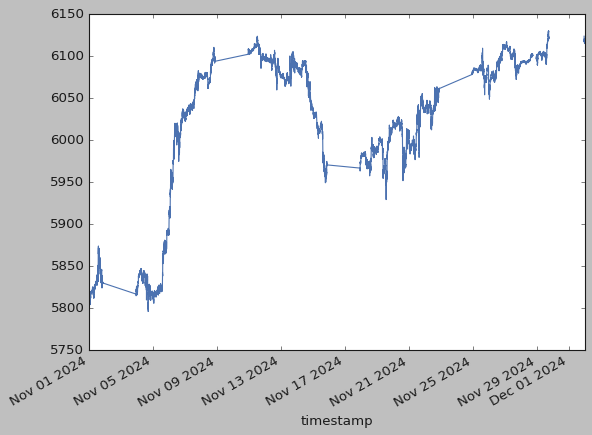

In [74]:
close = df.data["MES"].close
close.plot()
plt.show()

### Indicator

In [ ]:
def simple_indicator(close, period=10):
    def count_up_down_ratio(s):
        up = (s.diff() > 0).sum()
        down = (s.diff() < 0).sum()
        return (up - down) / (up + down) if (up + down) != 0 else np.nan

    return pd.Series(close).rolling(window=period).apply(count_up_down_ratio)

In [76]:
def make_indicator_with_func(indicator_func):
    SimpleIndicator = vbt.IndicatorFactory(
        class_name="SimpleIndicator",
        short_name="st",
        input_names=["close"],
        param_names=["period"],
        output_names=["udr"],
    ).with_apply_func(simple_indicator, takes_1d=True, period=10)
    return SimpleIndicator

In [77]:
# %%timeit
SimpleIndicator = make_indicator_with_func(simple_indicator)
indicator = SimpleIndicator.run(close, period=np.arange(5, 50, 5))

 11%|#1        | 1/9 [00:04<00:34,  4.30s/it, st_period=10]

In [78]:
indicator.udr.iloc[:1000].vbt.plot()

FigureWidget({
    'data': [{'name': '5',
              'showlegend': True,
              'type': 'scatter',
              'uid': '71faacea-3dcc-4432-9771-8253cdb2e5de',
              'x': array([datetime.datetime(2024, 11, 1, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2024, 11, 1, 0, 1, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2024, 11, 1, 0, 2, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2024, 11, 1, 16, 37, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2024, 11, 1, 16, 38, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2024, 11, 1, 16, 39, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([ nan,  nan,  nan, ..., -0.5, -0.5,  0. ])},
             {'name': '10',
              'showlegend': True,
              'type': 'scatter',
              'uid': '43efd0e2-7425-40b7-bcfa-b47

### Pipeline

In [99]:
def pipeline(close, period=10, upper=.5, lower=.5):
    indicator = SimpleIndicator.run(close, period=period)
    long_entries = indicator.udr < lower
    long_exits = indicator.udr > upper
    short_entries = long_exits
    short_exits = long_entries
    pf = vbt.Portfolio.from_signals(
        close,
        long_entries=long_entries,
        long_exits=long_exits,
        short_entries=short_entries,
        short_exits=short_exits,
        fees=0.0,
    )
    return pf

In [ ]:
pf = pipeline(df.data['MES'].close, period=np.arange(10,50, 5), upper=.4, lower=.4)
pf

In [ ]:
pf.stats()

c:\Users\spask\miniconda3\Lib\site-packages\vectorbtpro\generic\stats_builder.py:761: VBTWarning: Object has multiple columns. Aggregated some metrics using <function mean at 0x000001F7435B2520>. Pass either agg_func=None or per_column=True to return statistics per column. Pass column to select a single column or group.


Start Index                   2024-11-01 00:00:00+00:00
End Index                     2024-12-01 23:59:00+00:00
Total Duration                         19 days 21:17:00
Start Value                                       100.0
Min Value                                     99.769222
Max Value                                    106.017859
End Value                                    105.274084
Total Return [%]                               5.274084
Benchmark Return [%]                           5.289662
Position Coverage [%]                         99.907462
Max Gross Exposure [%]                       100.796968
Max Drawdown [%]                               3.116662
Max Drawdown Duration                  13 days 03:37:30
Total Orders                                    635.875
Total Fees Paid                                     0.0
Total Trades                                    635.875
Win Rate [%]                                  64.815295
Best Trade [%]                                 1

In [101]:
# TODO: continue here with parameterising the pipeline and optimizing the indicator with numba